In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
import importlib

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [2]:
importlib.reload(io)

path_plot = r'C:\Users\flori\Documents\lwf\plots\220512_flashtalk'

dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

paths, params_paths = io.find_paths_in_dirs(dir_names, tnr_number=11878)
# io.print_raster_info(paths)

1 dsms found in given directories, OK.
  -> Returning dsm: Tnr_11878_D-20210713_DSM.tif
1 dtms found in given directories, OK.
  -> Returning dtm: tnr_11878_dtm.tif
1 orthos found in given directories, OK.
  -> Returning ortho: Tnr_11878_D-20210713_Ortho.tif
-----------
Parameters:
  tnr                           : 11878
  path_dsm                      : C:\Data\lwf\DSM_2021\Tnr_11878_D-20210713_DSM.tif
  path_dtm                      : C:\Data\lwf\DTM\tnr_11878_dtm.tif
  path_ortho                    : C:\Data\lwf\Orthophotos_2021\Tnr_11878_D-20210713_Ortho.tif


### Reproject all rasters to same area & resolution -> Primary channels

In [3]:
importlib.reload(io)

# Set final pixel resolution of all rasters
px_width = 0.2

# Reproject all rasters
cs_prim, params_cs_prim = io.reproject_all_intersect(paths, px_width=px_width)

-----------
Parameters:
  crs                           : EPSG:25832
  affine                        : [[ 2.00000000e-01  0.00000000e+00  6.58459047e+05]
 [ 0.00000000e+00 -2.00000000e-01  5.45850800e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
  px_width                      : 0.2
  shape                         : (840, 804)
  bound_left                    : 658459.0469932929
  bound_bottom                  : 5458339.999947806
  bound_right                   : 658619.992780963
  bound_top                     : 5458507.999947806


### Normalize primary channels and compute secondary channels -> Secondary channels

In [4]:
importlib.reload(io)

downscale = 0
cs, params_cs = io.channels_primary_to_secondary(cs_prim, params_cs_prim, downscale=downscale)

-----------
Parameters:
  blue_wavelength               : 450
  green_wavelength              : 560
  red_wavelength                : 650
  re_wavelength                 : 730
  nir_wavelength                : 840
  downscale                     : 0
  px_width                      : 0.2
  shape                         : (840, 804)


### Segmentation -> Objects
#### (1) Segmentation
1. Local gaussian thresholding -> mask
2. Marker based watershed with markers generated by local peaks in distance transformation of mask

In [5]:
importlib.reload(segment)

params_segment = {
    # 'thresh_downscale':0,
    # 'water_downscale':1,
}

cs_segment, params_segment = segment.main(
    cs,
    params_cs,
    params_segment,
)

    ... [io.channels_primary_to_secondary()] already secondary channels!
    ... [io.channels_primary_to_secondary()] already secondary channels!
    ... [segmentation.local_thresholding()] Gaussian thresholding kernel width: 30.0 [m] = 75 [px]
    ... [segmentation.watershed_by_peaks_in_disttrafo()] Removing holes of area: 0.00 [m**2] = 0 [px]
    ... [segmentation.watershed_by_peaks_in_disttrafo()] Peaks in distance transform separated by minimum distance: 1.2 [m] = 5 [px]
-----------
Parameters:
  thresh_global_chm             : 3
  thresh_global_ndvi            : 0.4
  thresh_channel                : l
  thresh_downscale              : 1
  thresh_blur                   : False
  thresh_width                  : 30
  water_channel                 : l
  water_downscale               : 0
  water_peak_dist               : 1.2
  water_area_thresh             : 0.0
  water_label_min_size          : 5
  thresh_shape                  : (420, 402)
  thresh_px_width               : 0.4
  wate

#### (2) Plot segmentation results

<class 'matplotlib.axes._subplots.AxesSubplot'>


TypeError: isinstance() arg 2 must be a type or tuple of types

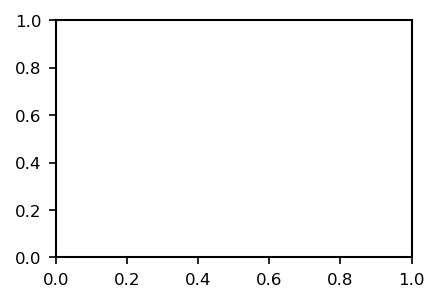

In [23]:
f, axs = plt.subplots(
    ncols=1,
    nrows=1,
)

print(type(axs))

import 

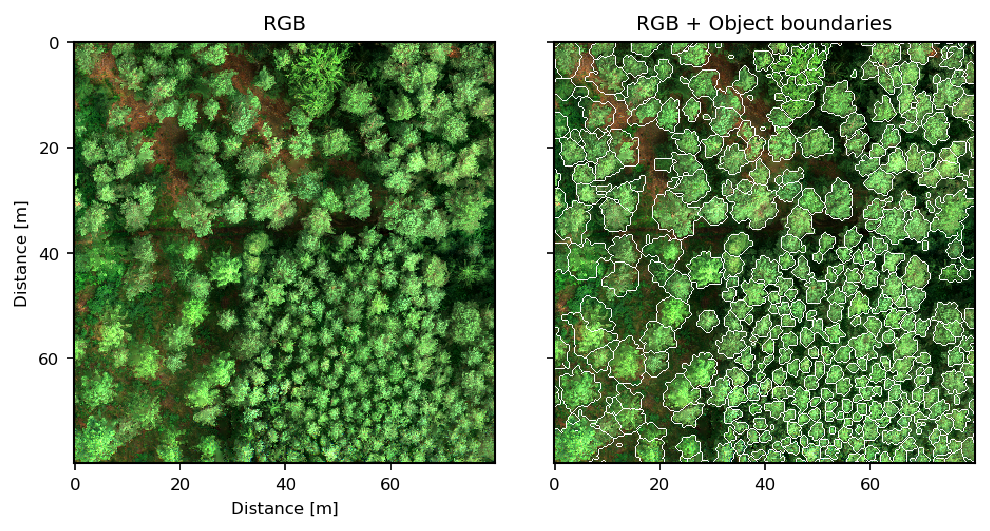

In [33]:
importlib.reload(visual)

# Adjust local mask and get distance transform for explanation of method
from scipy.ndimage.morphology import distance_transform_edt as distance_transform

mask_local = cs_segment['mask_seed'].copy()
mask_local[mask_local==2] = 1

dist_trafo = distance_transform(mask_local)

channels = [
    # cs['l'], mask_local, dist_trafo, 
    # cs_segment['mask_seed'],cs_segment['labels'],
    cs['RGB'],
    cs['RGB'],
]
channels_names = [
    # 'Lightness [L]', 'Local Mask by Gaussian thresholding in L', 'Distance transform [D] of local mask',
    # 'Local Mask + Markers (= Local peaks in D)', 'Objects by marker based watershed of -D*L',
    'RGB',
    'RGB + Object boundaries',
]
contrasts = [
    # (0,3.5e-2), (0,2), (0,10), 
    # None, None,
    (0.5,0.5),
    (0.5,0.5),
]
use_random_cmap = [False]
show_bounds = [False, True]

# ROI
width = 200
x_center = 500
y_center = 500
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    # mask=cs_segment['mask_global'],
    bounds=cs_segment['bounds'],
    show_bounds=show_bounds,
    contrasts=contrasts,
    channel_names=channels_names,
    # use_random_cmap=use_random_cmap,
    zoom=1.2,
    n_cols_rows=(2,1),
)

ticks_meter = [0, 20, 40, 60]
for i in [0]:
    axs[i].set_yticklabels(ticks_meter)
    axs[i].set_ylabel('Distance [m]')
for i in [0, 1]:    
    axs[0].set_xticklabels(ticks_meter)
    axs[0].set_xlabel('Distance [m]')

plt.savefig(os.path.join(path_plot, 'tnr' + params_paths['tnr'] + '_RGBzoom.svg'), format='svg', transparent=True)
plt.savefig(os.path.join(path_plot, 'tnr' + params_paths['tnr'] + '_RGBzoom.pdf'), format='pdf', transparent=True)

### Object properties
#### (1) Extract object properties

In [7]:
# importlib.reload(obj_props)
# props, names = obj_props.labels_to_props_all(cs_segment['labels'], cs, params_cs, include_labels=None)

In [8]:
# # print(names)

# xlim = [5e-3, 1]

# # Filter
# name = 'perc75_chm'
# positives = props[:, names.index(name)]
# positives = positives > 5

# select = [
#     'perc75_blue',
#     'perc75_green',
#     'perc75_red',
#     'perc75_re',
#     'perc75_nir',
#     ]

# # select = [
# #     'mean_upperl_blue',
# #     'mean_upperl_green',
# #     'mean_upperl_red',
# #     'mean_upperl_re',
# #     'mean_upperl_nir',
# #     ]

# # bins = np.linspace(0.5,1,70)
# bins= 50


# f, ax = plt.subplots(figsize=[4,3])
# for name in select:
#     _ = ax.hist(
#         props[:, names.index(name)][positives],
#         bins=bins,
#         histtype='step',
#         label=name,
#         )

# _ = ax.legend(loc='upper left',bbox_to_anchor=(1,1))
# # ax.set_xlim(xlim)
# # ax.set_xscale('log')

In [9]:
# # print(names)

# # Filter
# name = 'perc75_chm'
# positives = props[:, names.index(name)]
# positives = positives > 5

# # Variables
# name1 = 'std_ndre'
# feature1 = props[:, names.index(name1)]

# name2 = 'perc75_chm'
# feature2 = props[:, names.index(name2)]

# name3 = 'perc75_s'
# feature3 = props[:, names.index(name3)]

# x = feature1[positives]
# y = feature2[positives]
# z = feature3[positives]

# f, ax = plt.subplots(figsize=[4,3])
# _ = ax.scatter(
#     x,
#     y,
#     # c=z,
#     color='k',
#     s=5,
#     alpha=0.5,
#     )

# ax.set_xlabel(name1)
# ax.set_ylabel(name2)